In [1]:
%load_ext autoreload
%autoreload 2

In [95]:
import os
import sys
import importlib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy import hstack, vstack

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

sys.path.append('./')
sys.path.append('./operator_position')

sys.path.append('/Users/i.tolkachev/freelance/git/softpro/')
import odds

from tqdm import tqdm_notebook

tqdm_notebook().pandas()

In [5]:
data = pd.read_excel('/Users/i.tolkachev/freelance/softpro/20191125.xlsx', sheet_name='Sheet2')

In [6]:
data_nodups = data.drop(['Id', 'DateAdded'], axis=1).drop_duplicates()

In [15]:
columns_data = [c for c in data_nodups.columns.tolist() if not ('computed' in c or 'disc' in c)]

total_columns = [c for c in columns_data if 'TO' in c or 'TU' in c]
hdp_columns = [c for c in columns_data if 'HDP' in c]

In [18]:
def fair_odd(odd, margin):
    return (odd*(margin+1))

def margin_2(odd_1, odd_2):
    return 1/odd_1 + 1/odd_2 - 1

def margin_3(odd_1, odd_2, odd_3):
    return 1/odd_1 + 1/odd_2 + 1/odd_3 - 1

## Some samples of fitting odds probability 

In [65]:
totals_u.loc[:, 'to'] = totals[to_columns]
totals_u

,index,0,to
0,TU_1_5,2.85,NaN
1,TU_1_75,2.47,NaN
2,TU_2_0,2.08,NaN
3,TU_2_25,1.74,NaN
4,TU_2_5,1.558,NaN


In [71]:
pd.concat([totals[to_columns].reset_index(), totals[tu_columns].reset_index()], axis=1)

,index,0,index,0
0,TO_1_5,1.418,TU_1_5,2.85
1,TO_1_75,1.543,TU_1_75,2.47
2,TO_2_0,1.757,TU_2_0,2.08
3,TO_2_25,2.1,TU_2_25,1.74
4,TO_2_5,2.43,TU_2_5,1.558


In [89]:
totals

array([[2.85, 1.418],
       [2.47, 1.543],
       [2.08, 1.757],
       [1.74, 2.1],
       [1.558, 2.43]], dtype=object)

In [90]:
totals_u

array([2.85, 2.47, 2.08, 1.74, 1.558], dtype=object)

In [126]:
x = [0, 0.25, 0.5, 0.75]

coeffs = []

for i in tqdm_notebook(range(data_nodups.shape[0])):
    
    totals = data_nodups.iloc[i, :][total_columns]
    
    # find not NAN totals from line
    
    totals = totals[totals.notnull()]
    tu_columns = [c for c in totals.index if 'U' in c]
    to_columns = [c for c in totals.index if 'O' in c]
    totals_u = totals[tu_columns].values
    totals_o = totals[to_columns].values
    totals = vstack((totals_u, totals_o)).T 
    x, y = [], []
    for i, row in enumerate(totals):
        tu, to = row[0], row[1]
        margin = margin_2(to, tu)
        total_value = float(tu_columns[i][3:].replace('_', '.'))
        x.append(total_value) 
        y.append(1/fair_odd(tu, margin))

    ans = np.polyfit(x, y, 2)

    x=np.arange(x[0]-0.5, x[-1]+0.5, 0.01)
    
    def f(x):
        return sum(a*x**i for i, a in enumerate(ans))
    
    y=[f(x0) for x0 in x] 
    coeffs.append(ans)

Посмотрим на разброс коэффициентов

In [133]:
np_coeffs = np.array(coeffs)

print('Разброс, коэф при степени 0:', np.std(np_coeffs[:, 0]))
print('Разброс, коэф при степени 1:', np.std(np_coeffs[:, 1]))
print('Разброс, коэф при степени 2:', np.std(np_coeffs[:, 2]))

Разброс, коэф при степени 0: 0.01700812516549545
Разброс, коэф при степени 1: 0.1059848951289387
Разброс, коэф при степени 2: 0.2665468567752061


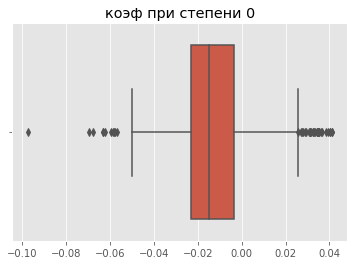

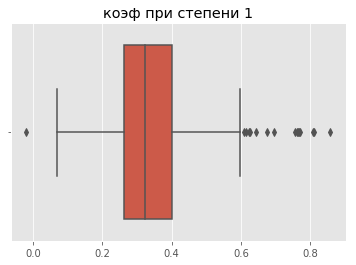

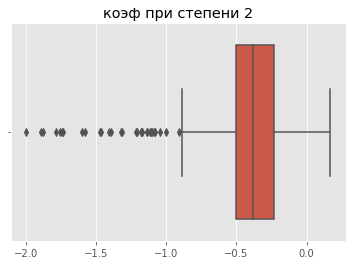

In [138]:
import seaborn as sns

sns.boxplot(np_coeffs[:, 0])
plt.title('коэф при степени 0')
plt.show()

sns.boxplot(np_coeffs[:, 1])
plt.title('коэф при степени 1')
plt.show()

sns.boxplot(np_coeffs[:, 2])
plt.title('коэф при степени 2')
plt.show()

##  Выводы
- коэффициенты имеют очевидный разброс, поэтому найти какую-то общую зависимость 
  между целыми, четвертичными и половинчатыми не удается
  
## Что можно попробовать
- посмотреть матчи, в которых есть несколько половинчатых тоталов, и приближенно решить систему уравнений,
  чтобы понять, минимизируется ли Loss до нуля для этой системы. Если нет, то получается, что вероятности 
  из разных тоталов принадлежат разным распределениям Пуассона, что опять даёт повод задуматься о возможности
  найти стабильно более точное решение.

In [ ]:
# plot example graphs

totals = data_nodups.iloc[0, :][total_columns]

# find not NAN totals from line

totals = totals[totals.notnull()]
tu_columns = [c for c in totals.index if 'U' in c]
to_columns = [c for c in totals.index if 'O' in c]
totals_u = totals[tu_columns].values
totals_o = totals[to_columns].values
totals = vstack((totals_u, totals_o)).T 
x, y = [], []
for i, row in enumerate(totals):
    tu, to = row[0], row[1]
    margin = margin_2(to, tu)
    total_value = float(tu_columns[i][3:].replace('_', '.'))
    x.append(total_value) 
    y.append(1/fair_odd(tu, margin))

plt.figure(figsize=(8, 8))
plt.scatter(x, y)
    


ans = np.polyfit(x, y, 2)
x=np.arange(x[0]-0.5, x[-1]+0.5, 0.01)

# polynomial function
def f1(x):
    return sum(a*x**i for i, a in enumerate(ans))

y=[f1(x0) for x0 in x] 

# plot fitted curve
plt.plot(x, y)
plt.show()